In [1]:
# import sys
# !{sys.executable} -m pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import cv2
import os.path
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw
%matplotlib inline

In [3]:
class InteriorLandmarksDataset(Dataset):

    def __init__(self, json_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open(json_file) as f:
            self.landmarks = json.load(f)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks)
    
    def displayOnCV2(self, image):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        cv2.imshow('img',image)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

        img_name = os.path.join(self.img_dir,
                                self.landmarks[idx]["file"])
        image = Image.open(img_name)
        landmarks = self.landmarks[idx]["points"]
        
        imgDraw = ImageDraw.Draw(image)  
        imgDraw.polygon(np.array(landmarks, dtype=np.int32), fill ="#eeeeff", outline = None)  
#TODO Fill the polygon
        segm = np.zeros_like(np.asarray(image))
        #segm = cv2.fillPoly(segm, np.array(landmarks, dtype=np.int32), 1)
        
        segm = Image.fromarray(segm)
        sample = {'image': image, 'segm': segm, 'idx': [idx]}

#         landmarks = np.array([landmarks])
#         landmarks = landmarks.astype('float').reshape(-1, 2)
#         sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = {'image': self.transform(image), 'segm': self.transform(segm), 'idx': [idx]}
            

        return sample

In [4]:
T = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
])

In [5]:
datasetLearn = InteriorLandmarksDataset('data/answersLearn.json', 'data/imgLearn', T)
datasetTest = InteriorLandmarksDataset('data/answersTest.json', 'data/imgTest', T)

In [6]:
sample = next(iter(datasetLearn))

In [7]:
sample['image'].shape

torch.Size([3, 256, 256])

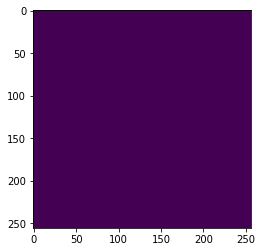

In [8]:
def vis_torch(sample):
    I = sample['image'].numpy().copy()
    
    gt = sample['segm'].numpy().copy()
    I[gt > 0] = 255
    plt.imshow(gt[0])


def vis(sample):
    I = np.asarray(sample['image']).copy()
    
    gt = np.asarray(sample['segm']).copy()
    I[gt > 0] = 255
    
#     for x, y in sample['landmarks']:
#         x, y = int(x), int(y)
#         I[y:y+10, x:x+10] = 0
    plt.imshow(gt)
vis_torch(sample)

In [9]:
trainloader = torch.utils.data.DataLoader(datasetLearn, batch_size=4, num_workers=0,
                                          shuffle=True)


Let's play with dataloader and model

In [10]:
minibatch = next(iter(trainloader))

In [11]:
from model import UNet
model = UNet(1)

In [12]:
# %%timeit
pred = model(minibatch['image'])

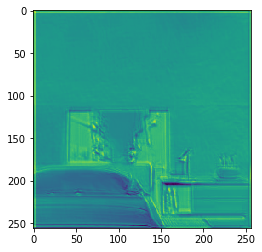

In [13]:
plt.imshow(pred[0, 0].detach().numpy())

In [ ]:
from model import UNet
import torch.nn as nn
import torch.optim as optim
model = UNet(3)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
trainloader = torch.utils.data.DataLoader(datasetLearn, batch_size=4, num_workers=0,
                                          shuffle=True)

i = 0
for minibatch in trainloader:
    inp = minibatch['image']
    gt = minibatch['segm']
    #ValueError: Target size (torch.Size([4, 3, 256, 256])) must be the same as input size (torch.Size([4, 1, 256, 256]))
    pred = model(inp)
    loss_ = loss(pred, gt)
    print(loss_.item())
    loss_.backward()
    optimizer.step()
    i += 1
    if i > 10:
        break

0.6926100850105286
0.6828992962837219


In [ ]:
minibatch['idx']

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model = torch.load('model.pth')